In [1]:
from entities import *
from constants import PICKLE_FILE, STAT_EFFECTS

import time
import requests
from bs4 import BeautifulSoup, Comment

import dowhy
from tqdm import tqdm, trange

import os
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings

# Suppress specific pandas FutureWarnings regarding Series.__getitem__
warnings.filterwarnings("ignore", category=FutureWarning, message=".*Series.__getitem__ treating keys as positions is deprecated.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*The default of observed=False is deprecated.*")

c:\Users\amgal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(PICKLE_FILE, 'rb') as f:
    teams = pickle.load(f)

Getting the players who start the game most often:

In [3]:
az = teams['Arizona']
starters = az.df['GS'].sort_values(ascending=False).iloc[:5]
starters

Player
Koa Peat            8
Jaden Bradley       8
Brayden Burries     8
Motiejus Krivas     8
Ivan Kharchenkov    8
Name: GS, dtype: int64

In [4]:
t = list(starters.index)
t.sort()
t

['Brayden Burries',
 'Ivan Kharchenkov',
 'Jaden Bradley',
 'Koa Peat',
 'Motiejus Krivas']

Getting a collection of 5 players based on how often they play:

In [5]:
pct_played = az.df['MP'] / (az.games * 40)
players = np.array(pct_played.index)
weights = np.array(pct_played) / np.array(pct_played).sum()

selection = np.random.choice(players, size=5, replace=False, p=weights)
selection.sort()
print(selection)


["Anthony Dell'Orso" 'Brayden Burries' 'Ivan Kharchenkov' 'Jaden Bradley'
 'Koa Peat']


In [6]:
az.df['MP'].sort_values(ascending=False)

Player
Koa Peat             221
Jaden Bradley        221
Brayden Burries      211
Anthony Dell'Orso    197
Motiejus Krivas      190
Ivan Kharchenkov     188
Tobe Awaka           155
Dwayne Aristode      134
Evan Nelson           28
Sidi Gueye            19
Addison Arnold        14
Sven Djopmo           10
Jackson Francois       6
Jackson Cook           6
Name: MP, dtype: int64

In [ ]:
dfs = []

for team in tqdm(teams.keys()):
    dfs.append(teams[team].causal_df)

df = pd.concat(dfs, ignore_index=True)
df.dropna(inplace=True)
df.head()

100%|██████████| 203/203 [00:00<00:00, 405256.41it/s]


,Team,Opp_Name,Tm,Opp_Score,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,oFG,oFGA,oFG%,o3P,o3PA,o3P%,o2P,o2PA,o2P%,oeFG%,oFT,oFTA,oFT%,oORB,oDRB,oTRB,oAST,oSTL,oBLK,oTOV,oPF
0,Abilene Christian,McMurry,92.0,55.0,34.0,69.0,0.493,6.0,20.0,0.300,28.0,49.0,0.571,0.536,18.0,26.0,0.692,17.0,34.0,51.0,21.0,7.0,7.0,13.0,15.0,18.0,63.0,0.286,8.0,31.0,0.258,10.0,32.0,0.313,0.349,11.0,15.0,0.733,7.0,18.0,25.0,10.0,6.0,5.0,16.0,20.0
1,Abilene Christian,Omaha,73.0,71.0,25.0,57.0,0.439,7.0,21.0,0.333,18.0,36.0,0.500,0.500,16.0,21.0,0.762,9.0,18.0,27.0,15.0,8.0,3.0,14.0,23.0,21.0,45.0,0.467,6.0,19.0,0.316,15.0,26.0,0.577,0.533,23.0,31.0,0.742,3.0,16.0,19.0,10.0,11.0,3.0,15.0,20.0
2,Abilene Christian,SW Adventist,104.0,63.0,43.0,68.0,0.632,9.0,22.0,0.409,34.0,46.0,0.739,0.699,9.0,12.0,0.750,11.0,23.0,34.0,26.0,9.0,3.0,11.0,16.0,22.0,50.0,0.440,4.0,15.0,0.267,18.0,35.0,0.514,0.480,15.0,18.0,0.833,4.0,11.0,15.0,6.0,7.0,0.0,19.0,12.0
3,Abilene Christian,Stephen F. Austin,66.0,76.0,24.0,57.0,0.421,2.0,10.0,0.200,22.0,47.0,0.468,0.439,16.0,19.0,0.842,8.0,27.0,35.0,12.0,4.0,5.0,10.0,21.0,24.0,53.0,0.453,13.0,23.0,0.565,11.0,30.0,0.367,0.575,15.0,26.0,0.577,4.0,22.0,26.0,14.0,5.0,5.0,7.0,15.0
4,Abilene Christian,Texas State,49.0,63.0,17.0,55.0,0.309,5.0,15.0,0.333,12.0,40.0,0.300,0.355,10.0,19.0,0.526,12.0,15.0,27.0,6.0,14.0,5.0,14.0,19.0,21.0,46.0,0.457,5.0,8.0,0.625,16.0,38.0,0.421,0.511,16.0,22.0,0.727,10.0,23.0,33.0,8.0,11.0,9.0,18.0,15.0


## Building our DAG

In [8]:
graph = """
digraph{

Tm;
STL -> oTOV;
STL -> PF -> oFTA -> oFT -> Opp_Score;

BLK -> o2P;
BLK -> o3P;
BLK -> oPF;

TOV -> 3PA -> 3P -> Tm;
TOV -> 2PA -> 2P -> Tm;
TOV -> o3PA -> o3P -> Opp_Score;
TOV -> o2PA -> o2P -> Opp_Score;

ORB -> 3PA;
ORB -> 2PA;

DRB -> o2PA;
DRB -> o3PA;
DRB -> TOV;

Opp_Score;
oSTL -> TOV;
oSTL -> oPF -> FTA -> FT -> Tm;

oBLK -> 2P;
oBLK -> 3P;
oBLK -> PF;

oTOV -> 3PA -> 3P -> Tm;
oTOV -> 2PA -> 2P -> Tm;
oTOV -> o3PA -> o3P -> Opp_Score;
oTOV -> o2PA -> o2P -> Opp_Score;

oORB -> o3PA;
oORB -> o2PA;

oDRB -> 2PA;
oDRB -> 3PA;
oDRB -> oTOV;
}
"""

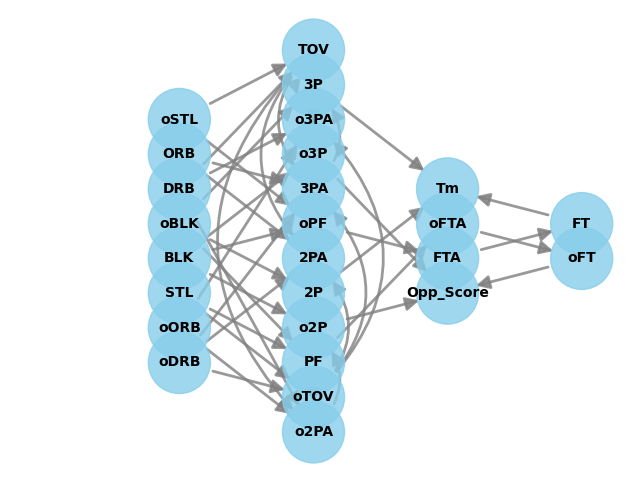

In [9]:
model = dowhy.CausalModel(data=df, graph=graph, treatment="2P",outcome="Tm")
model.view_model()

## Estimating Average Causal Effects

In [10]:
OUTCOMES = ['Tm', 'Opp_Score']

VARIABLES = ['2P',  '2PA',  '3P',  '3PA',  'FT',  'FTA',  'STL',  'BLK',  'TOV',  'PF',  'ORB',  'DRB',  # Team Stats
            'o2P', 'o2PA', 'o3P', 'o3PA', 'oFT', 'oFTA', 'oSTL', 'oBLK', 'oTOV', 'oPF', 'oORB', 'oDRB']  # Opponent Stats

In [11]:
treatment_effects = {}
for treatment in tqdm(VARIABLES):
    
    outcome_effects = {}
    for outcome in OUTCOMES:

        # Creating the Causal Model
        model = dowhy.CausalModel(
            data=df,
            graph=graph,
            treatment=treatment,
            outcome=outcome
        )

        # Identifying the Estimand
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimating the Estimand
        estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 target_units="ace")
        
        outcome_effects[outcome] = float(estimate.value)
    treatment_effects[treatment] = outcome_effects
        

100%|██████████| 24/24 [04:48<00:00, 12.00s/it]


In [14]:
treatment_effects

{'2P': {'Tm': 1.9811200570728005, 'Opp_Score': 0.0},
 '2PA': {'Tm': 1.1914108129813457, 'Opp_Score': 0.0},
 '3P': {'Tm': 2.973549049351959, 'Opp_Score': 0.0},
 '3PA': {'Tm': 0.9314343292847695, 'Opp_Score': 0.0},
 'FT': {'Tm': 1.1678924828682042, 'Opp_Score': 0.0},
 'FTA': {'Tm': 0.9026601299077655, 'Opp_Score': 0.0},
 'STL': {'Tm': 1.0277362860313417, 'Opp_Score': -0.7855066049016131},
 'BLK': {'Tm': 0.014569544170200288, 'Opp_Score': -0.5839268882034787},
 'TOV': {'Tm': -0.9199232408194291, 'Opp_Score': 0.8461038205378628},
 'PF': {'Tm': 0.0, 'Opp_Score': 1.0893521554062815},
 'ORB': {'Tm': 0.2598952957195735, 'Opp_Score': 0.0},
 'DRB': {'Tm': 0.7875228440373832, 'Opp_Score': -0.8897789617100926},
 'o2P': {'Tm': 0.0, 'Opp_Score': 2.005818784902253},
 'o2PA': {'Tm': 0.0, 'Opp_Score': 1.0543417920037612},
 'o3P': {'Tm': 0.0, 'Opp_Score': 2.9881094034231523},
 'o3PA': {'Tm': 0.0, 'Opp_Score': 0.9399301929616897},
 'oFT': {'Tm': 0.0, 'Opp_Score': 0.986505772335768},
 'oFTA': {'Tm': 0.0, 

In [15]:
with open(STAT_EFFECTS, 'wb') as f:
    pickle.dump(treatment_effects, f)